# Pyspark and SQL

Useful ressources: 
* https://www.tutorialspoint.com/spark_sql/spark_sql_quick_guide.htm
* https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/

Create DataFrames

In [1]:
from pyspark.sql import *
spark = SparkSession\
    .builder\
    .getOrCreate()

23/02/26 21:49:07 WARN Utils: Your hostname, vincent-Inspiron-5558 resolves to a loopback address: 127.0.1.1; using 192.168.1.73 instead (on interface wlp6s0)
23/02/26 21:49:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/26 21:49:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/26 21:49:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/02/26 21:49:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee1, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print(department1)
print(employee2)
print(departmentWithEmployees1.employees[0].email)


Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu


Create DataFrames from a list of the rows

In [3]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)

df1.show()
        
departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)

df2.show()


+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|{123456, Computer...|[{michael, armbru...|
|{789012, Mechanic...|[{matei, null, no...|
+--------------------+--------------------+

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|{345678, Theater ...|[{michael, armbru...|
|{901234, Indoor R...|[{xiangrui, meng,...|
+--------------------+--------------------+



# Work with DataFrames
## Union two DataFrames

In [4]:
unionDF = df1.unionAll(df2)
unionDF.show()


+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|{123456, Computer...|[{michael, armbru...|
|{789012, Mechanic...|[{matei, null, no...|
|{345678, Theater ...|[{michael, armbru...|
|{901234, Indoor R...|[{xiangrui, meng,...|
+--------------------+--------------------+



Write the unioned DataFrame to a Parquet file

In [8]:
# Remove the file if it exists
unionDF.write.parquet("./databricks-df-example.parquet")


Read a DataFrame from the Parquet file

In [9]:
parquetDF = spark.read.parquet("./databricks-df-example.parquet")
parquetDF.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|{345678, Theater ...|[{michael, armbru...|
|{789012, Mechanic...|[{matei, null, no...|
|{123456, Computer...|[{michael, armbru...|
|{901234, Indoor R...|[{xiangrui, meng,...|
+--------------------+--------------------+



## Explode the employees column

In [10]:
from pyspark.sql.functions import explode
df = unionDF.select(explode("employees").alias("e"))
explodeDF = df.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")

explodeDF.show()


+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
|     null| wendell|no-reply@berkeley...|160000|
|  michael|armbrust|no-reply@berkeley...|100000|
|     null| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



## Use filter() to return the rows that match a predicate

In [11]:
filterDF = explodeDF.filter(explodeDF.firstName == "xiangrui").sort(explodeDF.lastName)
filterDF.show()


+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



In [12]:
from pyspark.sql.functions import col, asc

# Use `|` instead of `or`
filterDF = explodeDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
filterDF.show()


+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



The where() clause is equivalent to filter()

In [13]:
whereDF = explodeDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
whereDF.show()


+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



Replace null values with -- using DataFrame Na function

In [14]:
nonNullDF = explodeDF.fillna("--")
nonNullDF.show()


+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
|       --| wendell|no-reply@berkeley...|160000|
|  michael|armbrust|no-reply@berkeley...|100000|
|       --| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



Retrieve only rows with missing firstName or lastName

In [15]:
filterNonNullDF = explodeDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")
filterNonNullDF.show()


+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|     null| wendell|no-reply@berkeley...|160000|
|     null| wendell|no-reply@berkeley...|160000|
|    matei|    null|no-reply@waterloo...|140000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



Example aggregations using agg() and countDistinct()

In [16]:
from pyspark.sql.functions import countDistinct

countDistinctDF = explodeDF.select("firstName", "lastName")\
  .groupBy("firstName", "lastName")\
  .agg(countDistinct("firstName"))

countDistinctDF.show()


+---------+--------+----------------+
|firstName|lastName|count(firstName)|
+---------+--------+----------------+
| xiangrui|    meng|               1|
|  michael|armbrust|               1|
|     null| wendell|               0|
|    matei|    null|               1|
+---------+--------+----------------+



## Compare the DataFrame and SQL query physical plans

In [17]:
countDistinctDF.explain()
# register the DataFrame as a temp table so that we can query it using SQL
explodeDF.registerTempTable("databricks_df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = spark.sql("SELECT firstName, lastName, count(distinct firstName) as distinct_first_names FROM databricks_df_example GROUP BY firstName, lastName")

countDistinctDF_sql.explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[firstName#70, lastName#71], functions=[count(distinct firstName#70)])
   +- HashAggregate(keys=[firstName#70, lastName#71], functions=[partial_count(distinct firstName#70)])
      +- HashAggregate(keys=[firstName#70, lastName#71, firstName#70], functions=[])
         +- Exchange hashpartitioning(firstName#70, lastName#71, firstName#70, 200), ENSURE_REQUIREMENTS, [plan_id=568]
            +- HashAggregate(keys=[firstName#70, lastName#71, firstName#70], functions=[])
               +- Project [e#68.firstName AS firstName#70, e#68.lastName AS lastName#71]
                  +- Generate explode(employees#1), false, [e#68]
                     +- Union
                        :- Project [employees#1]
                        :  +- Filter ((size(employees#1, true) > 0) AND isnotnull(employees#1))
                        :     +- Scan ExistingRDD[department#0,employees#1]
                        +- Project [employees

/home/vincent/.local/share/virtualenvs/formation_utt_solutions-DIwusHoz/lib/python3.10/site-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


Sum up all the salaries

In [18]:
salarySumDF = explodeDF.agg({"salary" : "sum"})
salarySumDF.show()

type(explodeDF.salary)



+-----------+
|sum(salary)|
+-----------+
|    1040000|
+-----------+



pyspark.sql.column.Column

Print the summary statistics for the salaries

In [19]:
explodeDF.describe("salary").show()


+-------+------------------+
|summary|            salary|
+-------+------------------+
|  count|                 8|
|   mean|          130000.0|
| stddev|23904.572186687874|
|    min|            100000|
|    max|            160000|
+-------+------------------+



An example using pandas and Matplotlib integration

<Figure size 640x480 with 0 Axes>

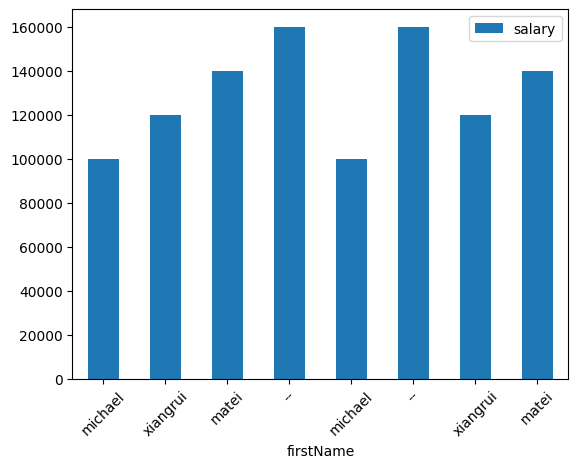

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
plt.show()

See also for more information: 
* https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html
* https://spark.apache.org/docs/latest/sql-programming-guide.html